# Линейные модели в машинном обучении

В данном проекте мы поможем фермеру на основе информации о его коровах, подобрать новых к покупке коров. Ключевыми призаками для фермера являются 'удой' и 'вкус молока'. Мы сделаем прогнозы при помощью моделей машинного обучения. 

Для начала мы изучим данные, предоставленные фермером с информацией о коровах, молоке и прочему, а также данные предоставленные компанией 'экоферма', с коровами, выставленными на продажу. Стандартизируем данные, удалим дубликаты, разберемся с пропусками. 

Далее проведем исследовательских анализ данных, предоставленный фермером. Построим графики по всем признакам, чтобы увидеть, есть ли какие-то аномалии в данных.

После этого проведем корреляционный анализ признаков в данных фермера, изучим взаимосвязь между признаками: линейная или нелинейная, присутсвтует ли мультиколлинеарность.

После этого будем создавать модель линейной регрессии для прогноза количесвтенного признака - удоя. Посмотрим ее результаты и постараемся улучшить, если это возможно. 

Потом перейдем к другой задаче - будем определять признак 'вкус молока'. Для него создадим модель логистической регрессии на данных фермера. Посмотрим на результаты работы и на метрики, постараемся улучшить, если это возможно.

В конце мы напишем вывод с рекомендацией к покупке для фермера.

In [521]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

In [522]:
RANDOM_STATE = 42

## Загрузка данных

In [523]:
try:
    ferma_main = pd.read_csv('/datasets/ferma_main.csv', sep=';', decimal=',')
    ferma_dad = pd.read_csv('/datasets/ferma_dad.csv', sep=';', decimal=',')
    cow_buy = pd.read_csv('/datasets/cow_buy.csv', sep=';', decimal=',')
except:
    ferma_main = pd.read_csv('C/datasets/ferma_main.csv', sep=';', decimal=',')
    ferma_dad = pd.read_csv('C/datasets/ferma_dad.csv', sep=';', decimal=',')
    cow_buy = pd.read_csv('C/datasets/cow_buy.csv', sep=';', decimal=',')

Посмотрим на наши датафреймы.

In [524]:
ferma_main.head()

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


In [525]:
ferma_dad.head()

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [526]:
cow_buy.head()

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


Преобразуем названия столбцов к змеиному регистру: сделаем все буквы прописными, а пробелы между словами заменим на '_'. Так же удалим из колонок, содержащих аббревиатуры, их расшифровки (т.к. они занимают много места), и уберем единицы измерения из названий. 

In [527]:
# убираем пробелы слева и справа от названий (если такие есть). делаем все буквыми маленькими и заменяем пробелы на '_'
ferma_main.columns = ferma_main.columns.str.strip().str.lower().str.replace(' ', '_')
#замним оставшееся вручную
ferma_main = ferma_main.rename(columns={'id' : 'ид', 'удой,_кг': 'удой', 'эке_(энергетическая_кормовая_единица)' : 'эке', 'сырой_протеин,_г': 'сырой_протеин', 'спо_(сахаро-протеиновое_соотношение)' : 'спо', 'жирность,%' : 'жирность', 'белок,%' : 'белок'})
#делаем аналогичную процедуру для двух других таблиц
ferma_dad.columns = ferma_dad.columns.str.strip().str.lower().str.replace(' ', '_')
ferma_dad = ferma_dad.rename(columns={'id' : 'ид'})
cow_buy.columns = cow_buy.columns.str.strip().str.lower().str.replace(' ', '_')
cow_buy = cow_buy.rename(columns={'текущая_жирность,%' : 'текущая_жирность', 'текущий_уровень_белок,%' : 'текущий_уровень_белка'})

In [528]:
cow_buy.head()

,порода,тип_пастбища,порода_папы_быка,имя_папы,текущая_жирность,текущий_уровень_белка,возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


Первичные преобразования сделаны, таблицы соответсвуют стандартам оформления. Приступим к дальнейшему изучения данных в таблицах.

##  Предобработка данных

Теперь посмотрим на суммарную информацию о таблицах.

Рассмотрим таблицу 'ferma_main'.

In [529]:
ferma_main.isna().sum()

ид                  0
удой                0
эке                 0
сырой_протеин       0
спо                 0
порода              0
тип_пастбища        0
порода_папы_быка    0
жирность            0
белок               0
вкус_молока         0
возраст             0
dtype: int64

In [530]:
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ид                634 non-null    int64  
 1   удой              634 non-null    int64  
 2   эке               634 non-null    float64
 3   сырой_протеин     634 non-null    int64  
 4   спо               634 non-null    float64
 5   порода            634 non-null    object 
 6   тип_пастбища      634 non-null    object 
 7   порода_папы_быка  634 non-null    object 
 8   жирность          634 non-null    float64
 9   белок             634 non-null    float64
 10  вкус_молока       634 non-null    object 
 11  возраст           634 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.6+ KB


Рассмотрим таблицу 'ferma_dad'.

In [531]:
ferma_dad.isna().sum()

ид          0
имя_папы    0
dtype: int64

In [532]:
ferma_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ид        629 non-null    int64 
 1   имя_папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


C этой таблицей все хорошо: отсутсвуют пропуски и данные выражены нужными типами данных.

Рассмотрим таблицу 'cow_buy'.

In [533]:
cow_buy.isna().sum()

порода                   0
тип_пастбища             0
порода_папы_быка         0
имя_папы                 0
текущая_жирность         0
текущий_уровень_белка    0
возраст                  0
dtype: int64

In [534]:
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   порода                 20 non-null     object 
 1   тип_пастбища           20 non-null     object 
 2   порода_папы_быка       20 non-null     object 
 3   имя_папы               20 non-null     object 
 4   текущая_жирность       20 non-null     float64
 5   текущий_уровень_белка  20 non-null     float64
 6   возраст                20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


С ней все хорошо. Теперь проверим датафреймы на наличие дубликатов. Но для начала проверим, нет ли опечаток в строковых колонках. Для этого посмотрим какими уникальными значениями предаствлены различные колонки.

In [535]:
print('Таблица "ferma_main:"')
print(ferma_main['порода'].unique())
print(ferma_main['тип_пастбища'].unique())
print(ferma_main['порода_папы_быка'].unique())
print(ferma_main['вкус_молока'].unique())
print(ferma_main['возраст'].unique())
print()
print('Таблица "cow_buy:"')
print(cow_buy['порода'].unique())
print(cow_buy['тип_пастбища'].unique())
print(cow_buy['имя_папы'].unique())
print(cow_buy['возраст'].unique())
print()
print('Таблица "ferma_dad:"')
print(ferma_dad['имя_папы'].unique())

Таблица "ferma_main:"
['Вис Бик Айдиал' 'РефлешнСоверинг']
['Равнинное' 'Равнинные' 'Холмистое']
['Айдиал' 'Соверин' 'Айдиалл']
['вкусно' 'не вкусно']
['более_2_лет' 'менее_2_лет']

Таблица "cow_buy:"
['Вис Бик Айдиал' 'РефлешнСоверинг']
['холмистое' 'равнинное']
['Геркулес' 'Буйный' 'Барин' 'Соловчик']
['более_2_лет' 'менее_2_лет']

Таблица "ferma_dad:"
['Буйный' 'Соловчик' 'Барин' 'Геркулес']


Видим, что в таблице 'ferma_main' присутсвуют опечатки. В типе пастбища: 'равнинное' и 'равнинные' - это один и тот же тип. Анлогичная ситуация с породой папы быка: 'Айдиал' и 'Айдиалл' - это одно и тоже.  Поэтому преобразуем эти значения. И чтобы эти значения были такими же как в таблице 'cow_buy', переведем их в нижний регистр.

In [536]:
ferma_main.loc[(ferma_main['тип_пастбища'] == 'Равнинное') | (ferma_main['тип_пастбища'] == 'Равнинные'), 'тип_пастбища'] = 'равнинное'
ferma_main.loc[ferma_main['тип_пастбища'] == 'Холмистое', 'тип_пастбища'] = 'холмистое'
ferma_main.loc[ferma_main['порода_папы_быка'] == 'Айдиалл', 'порода_папы_быка'] = 'Айдиал'

In [537]:
ferma_main.duplicated().sum()

5

In [538]:
ferma_dad.duplicated().sum()

0

In [539]:
cow_buy.duplicated().sum()

4

Таблица 'ferma_main' содержит 5 дубликатов, а таблица 'cow_buy' - 4 дубликата. Удалим их.

In [540]:
ferma_main = ferma_main.drop_duplicates().reset_index(drop=True)
cow_buy = cow_buy.drop_duplicates().reset_index(drop=True)

In [541]:
cow_buy.head()

,порода,тип_пастбища,порода_папы_быка,имя_папы,текущая_жирность,текущий_уровень_белка,возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


Также имеет смысл совместить таблицы 'ferma_main' и 'ferma_dad', чтобы в основной таблице была полная информация о коровах.

In [542]:
ferma_main = ferma_main.merge(ferma_dad, on='ид', how='left') 

Предобрадотка выполнена. Данные в колонках представлены нужными типами, дубликаты отсутствуют.

## Исследовательский анализ данных

### 3.1 Статистический анализ признаков

Изучим параметры, которые характерезуют коров, корм и молоко фермера. А потом посмотрим на параметры коров, которые предложены фермеру к покупке, а также харакеристики их молока.

#### Таблица 'ferma_main'.

Для начала изучим числовые параметры.

In [543]:
ferma_main.describe()

,ид,удой,эке,сырой_протеин,спо,жирность,белок
count,629.00000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000
mean,315.00000,6188.750397,14.543879,1923.364070,0.913116,3.603657,3.075671
std,181.72094,1644.795489,1.306408,182.956251,0.032203,0.168656,0.002549
min,1.00000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,158.00000,5751.000000,13.500000,1771.000000,0.890000,3.590000,3.074000
50%,315.00000,6133.000000,14.700000,1888.000000,0.930000,3.650000,3.076000
75%,472.00000,6501.000000,15.600000,2062.000000,0.940000,3.720000,3.077000
max,629.00000,45616.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


Теперь посмотрим на качественные переменные.

In [544]:
ferma_main['вкус_молока'].value_counts() / len(ferma_main)

вкусно       0.589825
не вкусно    0.410175
Name: вкус_молока, dtype: float64

In [545]:
ferma_main['порода'].value_counts() / len(ferma_main)

Вис Бик Айдиал     0.593005
РефлешнСоверинг    0.406995
Name: порода, dtype: float64

In [546]:
ferma_main['тип_пастбища'].value_counts() / len(ferma_main)

холмистое    0.558029
равнинное    0.441971
Name: тип_пастбища, dtype: float64

In [547]:
ferma_main['порода_папы_быка'].value_counts() / len(ferma_main)

Айдиал     0.505564
Соверин    0.494436
Name: порода_папы_быка, dtype: float64

In [548]:
ferma_main['возраст'].value_counts() / len(ferma_main)

более_2_лет    0.825119
менее_2_лет    0.174881
Name: возраст, dtype: float64

##### Харакеристика коров фермера

Большинство коров фермера (около 83%) старше 2х лет. Коровы фермера двух пород: Вис Бик Айдиал (59%) и РефлешнСоверинг (41%). А породы папы быка у коров делятся пополам: половина Айдиал, а другая половина Соверин.

##### Характеристика пастбища

Пасутся же коровы на холмистой и равнинной местности, с небольшим преобладанием (на ~5%) холмистой местности. 

##### Характеристика корма фермера

Среднее ЭКЕ (энергетической кормовой единицы) составляет 14.5, сырого протеина около 1923 г, а СПО (сахаро-протеинового соотношения) - 0.91.

##### Характеристика молока

Поголовье фермера находится в порядке: средний удой за год превышает 6000 кг и составляет порядка 6188 кг. Жирность молока около ~3.6%, а белок составляет ~3.1%. По вкусу, большая часть молока (около 59%) является вкусной.

#### Таблица 'cow_buy'.

Изучим числовые и категориальные параметры таблицы 'cow_buy'.

In [549]:
cow_buy.describe()

,текущая_жирность,текущий_уровень_белка
count,16.000000,16.000000
mean,3.571875,3.068250
std,0.141620,0.011264
min,3.340000,3.046000
25%,3.415000,3.059500
50%,3.585000,3.073500
75%,3.692500,3.076750
max,3.770000,3.081000


In [550]:
cow_buy['порода'].value_counts()

РефлешнСоверинг    8
Вис Бик Айдиал     8
Name: порода, dtype: int64

In [551]:
cow_buy['тип_пастбища'].value_counts()

холмистое    8
равнинное    8
Name: тип_пастбища, dtype: int64

In [552]:
cow_buy['возраст'].value_counts()

более_2_лет    11
менее_2_лет     5
Name: возраст, dtype: int64

Фермеру предлагается 16 коров, половина из которых породы Вис Бик Айдиал, а другая половина РефлешнСоверинг. По типу пастбища опять таки, для половины коров использовалась холмистая местность, а для другой равнинная. Большинство коров (11) старше двух лет. Но наиболее интересная информация для нас заключена в параметрах молока, которое дают эти коровы. Так, средняя жирность находится на уровне ~3.6%, а белок составляет ~3.1%, что совпадает с параметрами молока фермера.

### 3.2 Графики признаков

#### Таблица 'ferma_main'.

Для большей наглядности построим графики, вычесленных выше параметров.

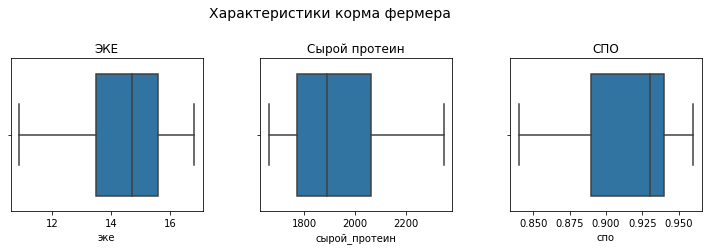

In [553]:
plt.figure(figsize=(12, 4))
plt.suptitle('Характеристики корма фермера', fontsize=14)
plt.subplots_adjust(left=0.13, 
                    right=0.93, 
                    top=0.80, 
                    bottom= 0.27, 
                    wspace= 0.3, 
                    hspace=0.3)

plt.subplot(1, 3, 1)
plt.title('ЭКЕ')
sns.boxplot(x='эке', data=ferma_main);

plt.subplot(1, 3, 2)
plt.xlabel('граммы')
plt.title('Сырой протеин')
sns.boxplot(x='сырой_протеин', data=ferma_main)

plt.subplot(1, 3, 3)
plt.title('СПО')
sns.boxplot(x='спо', data=ferma_main)
plt.show()

Исходя из графиков видно, что все числовые характеристики корма не имеют выбросов.

Далее визуализируем информацию о коровах фермера. 

<AxesSubplot:title={'center':'Тип пастбища'}, xlabel='тип_пастбища', ylabel='count'>

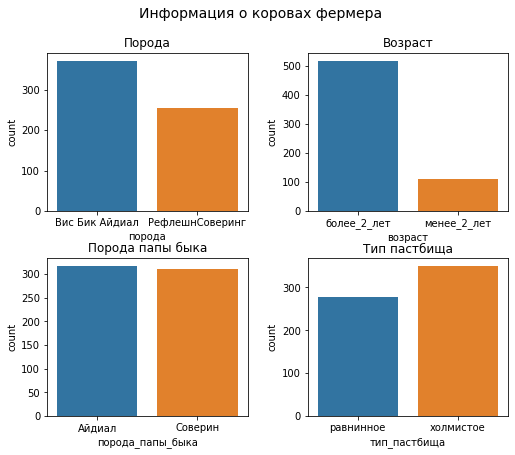

In [554]:
plt.figure(figsize=(8, 8))
plt.suptitle('Информация о коровах фермера', fontsize=14)
plt.subplots_adjust(left=0.13, 
                    right=0.93, 
                    top=0.90, 
                    bottom= 0.27, 
                    wspace= 0.3, 
                    hspace=0.3)

plt.subplot(2, 2, 1)
plt.title('Порода')
plt.ylabel('количество')
sns.countplot(x=ferma_main['порода'])

plt.subplot(2, 2, 2)
plt.title('Возраст')
plt.ylabel('количество')
sns.countplot(x=ferma_main['возраст'])

plt.subplot(2, 2, 3)
plt.title('Порода папы быка')
plt.ylabel('количество')
sns.countplot(x=ferma_main['порода_папы_быка'])

plt.subplot(2, 2, 4)
plt.title('Тип пастбища')
plt.ylabel('количество')
sns.countplot(x=ferma_main['тип_пастбища'])


На графиках явно видно, что молодых коров (моложе 2х лет) намного меньше, чем коров, которым 2 и более лет. А по остальным призакам нет сущесвтенного различия.

Далее взглянем на признаки молока фермера.

<AxesSubplot:title={'center':'Вкус молока'}, xlabel='вкус_молока', ylabel='count'>

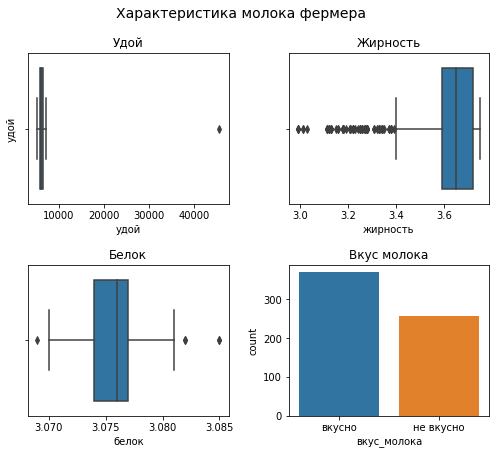

In [555]:
plt.figure(figsize=(8, 8))
plt.suptitle('Характеристика молока фермера', fontsize=14)
plt.subplots_adjust(left=0.13, 
                    right=0.93, 
                    top=0.90, 
                    bottom= 0.27, 
                    wspace= 0.3, 
                    hspace=0.4)

plt.subplot(2, 2, 1)
plt.title('Удой')
plt.ylabel('удой')
sns.boxplot(data=ferma_main, x='удой')

plt.subplot(2, 2, 2)
plt.title('Жирность')
sns.boxplot(data=ferma_main, x='жирность')

plt.subplot(2, 2, 3)
plt.title('Белок')
sns.boxplot(data=ferma_main, x='белок')

plt.subplot(2, 2, 4)
plt.title('Вкус молока')
sns.countplot(x=ferma_main['вкус_молока'])

По графикам, связанным с молоком видно, что вкусного молока у фермера больше, чем не вкусного. На графиках числовых характеристик присутсвуют выбросы.

#### Таблица 'cow_buy'.

Теперь посмотрим на признаки коров и молока коров, которых фермер рассматривает к покупке.

<AxesSubplot:title={'center':'Белок'}, xlabel='текущий_уровень_белка'>

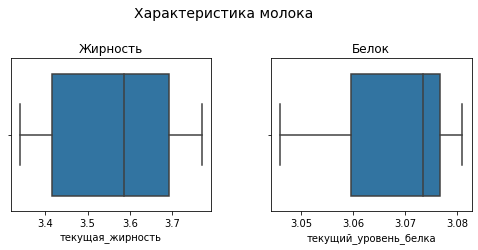

In [556]:
plt.figure(figsize=(8, 4))
plt.suptitle('Характеристика молока', fontsize=14)
plt.subplots_adjust(left=0.13, 
                    right=0.93, 
                    top=0.80, 
                    bottom= 0.27, 
                    wspace= 0.3, 
                    hspace=0.4)
plt.subplot(1, 2, 1)
plt.title('Жирность')
sns.boxplot(data=cow_buy, x='текущая_жирность')

plt.subplot(1, 2, 2)
plt.title('Белок')
sns.boxplot(data=cow_buy, x='текущий_уровень_белка')


Выброс среди числовых параметров молока нет.

Теперь посмотрим на характеристики коров.

<AxesSubplot:title={'center':'Тип пастбища'}, xlabel='тип_пастбища', ylabel='count'>

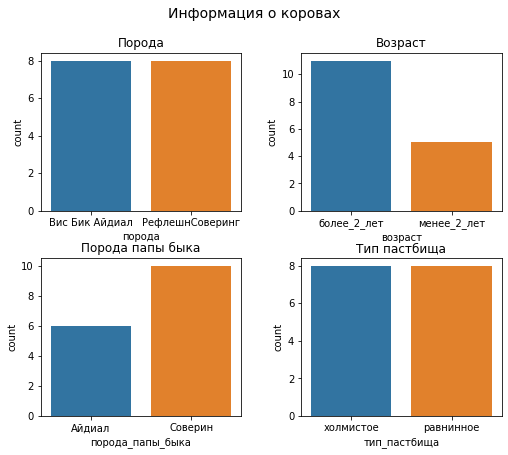

In [557]:
plt.figure(figsize=(8, 8))
plt.suptitle('Информация о коровах', fontsize=14)
plt.subplots_adjust(left=0.13, 
                    right=0.93, 
                    top=0.90, 
                    bottom= 0.27, 
                    wspace= 0.3, 
                    hspace=0.3)

plt.subplot(2, 2, 1)
plt.title('Порода')
plt.ylabel('количество')
sns.countplot(x=cow_buy['порода'])

plt.subplot(2, 2, 2)
plt.title('Возраст')
plt.ylabel('количество')
sns.countplot(x=cow_buy['возраст'])

plt.subplot(2, 2, 3)
plt.title('Порода папы быка')
plt.ylabel('количество')
sns.countplot(x=cow_buy['порода_папы_быка'])

plt.subplot(2, 2, 4)
plt.title('Тип пастбища')
plt.ylabel('количество')
sns.countplot(x=cow_buy['тип_пастбища'])

Видно, что коров, старше 2х лет больше.

#### Вывод

После построения графиков, стало понятно, что в таблице 'ferma_main' присутсвуют выбросы в характеристиках молока. Есть одно значения, характеризующее удой, которое сильно выбивается. Если в среднем удой около 6188 кг, то это значения больше 40000 кг. Возможно фермер допустил опечатку и поставил лишний 0. Чтобы в будущем наши предсказания были более точными я бы исключил строку, содержащую необычное значение в колонки 'удой'.

In [558]:
#ferma_main = ferma_main[(ferma_main['удой'] < 10000) & (3.070 < ferma_main['белок']) & (ferma_main['белок'] < 3.081)].reset_index(drop=True)

In [559]:
ferma_main = ferma_main[ferma_main['удой'] < 10000].reset_index(drop=True)

## Корреляционный анализ

### 4.1 Взаимосвязь между признаками таблиицы 'ferma_main'

Изучим взаимосвязь между числовыми признаками в таблице 'ferma_main', рассчитав коэффиценты корреляции.

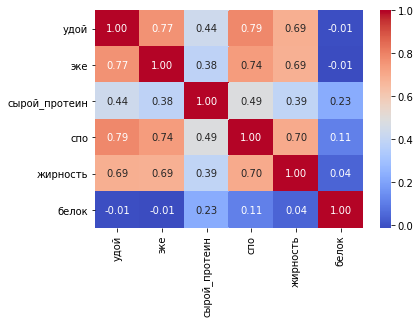

In [560]:
#визуализируем матрицу корреляции. для этого сделаем маску по ferma_main, оставив колонки с числовыми признаками. 
#но начнем со 2 значения, тк 1 - это ИД коровы 
sns.heatmap(ferma_main[ferma_main.describe().columns[1:]].corr(method='spearman'), annot=True, cmap='coolwarm', fmt='.2f');

По таблице корреляции видно, что удой сильно коррелируют с эке и спо, чуть меньше с жирностью и еще меньше с сырым протеином, но совсем не коррелирует с белком. Также видна прямая корреляция между эке и спо, эке и жирностью, а так же между спо и жирностью.

### 4.2 Диаграммы рассеяния между колонкой 'удой' и всеми количественными признаками.

Создадим функцию для отрисовки диаграмм рассеяния между колонкой 'удой' и другими 

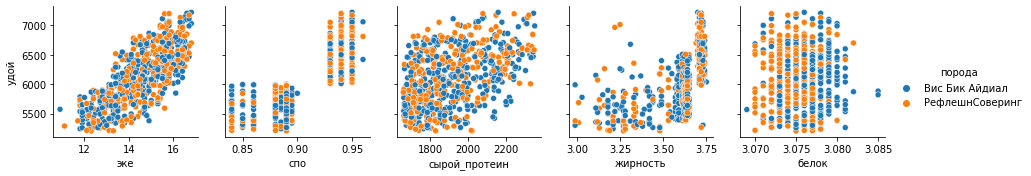

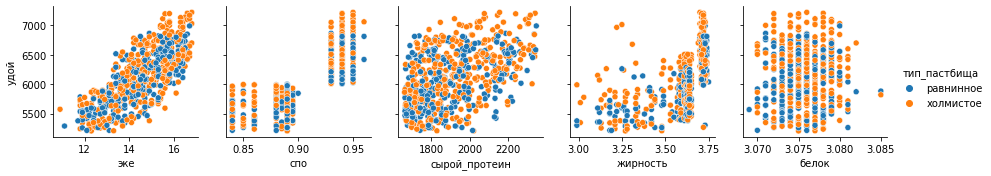

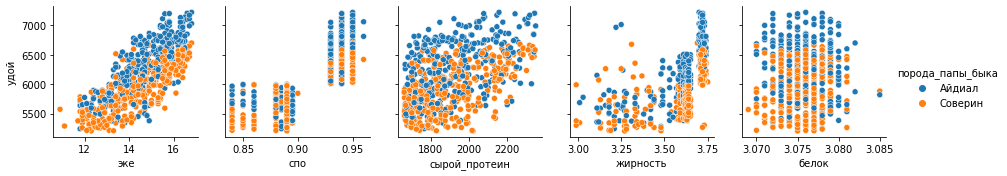

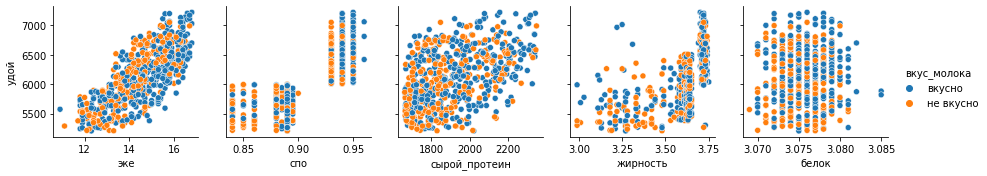

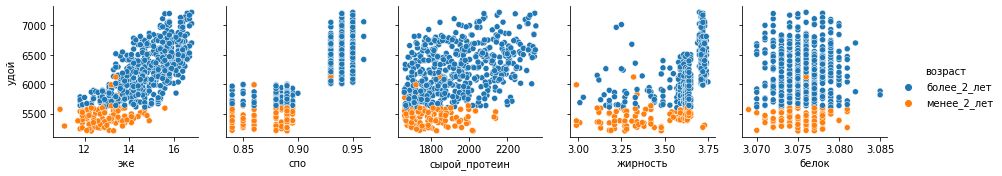

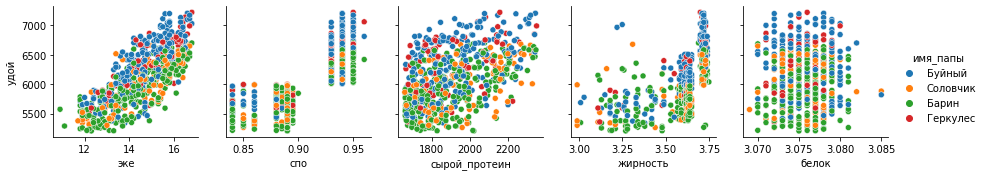

In [561]:
cat = ['порода', 'тип_пастбища', 'порода_папы_быка', 'вкус_молока', 'возраст', 'имя_папы']
for category in cat:
            g = sns.PairGrid(ferma_main, hue = category, x_vars=['эке', 'спо','сырой_протеин', 'жирность', 'белок'], y_vars='удой')
            g.map(sns.scatterplot)
            g.add_legend()            

По графикам видно, что единственный признак, который может линейно зависеть от 'удоя' - это 'эке'. Но стоит рассмотреть также как зависит от 'удоя' 'эке^2', возможно зависимость в этом случае будет более линейной. А сравним мы их с помощью метрики r2.

In [562]:
#создаем новую колонку, где будут храниться значения эке^2
ferma_main['эке_в_квадрате'] = ferma_main['эке'] ** 2
#рассчитываем метрики r2
r2_eke = r2_score(ferma_main['удой'], ferma_main['эке'])
r2_eke_2 = r2_score(ferma_main['удой'], ferma_main['эке_в_квадрате'])
print(r2_eke, r2_eke_2)

-165.2008497317639 -154.51717384115244


И построим графики для отображения зависимости

<Figure size 288x576 with 0 Axes>

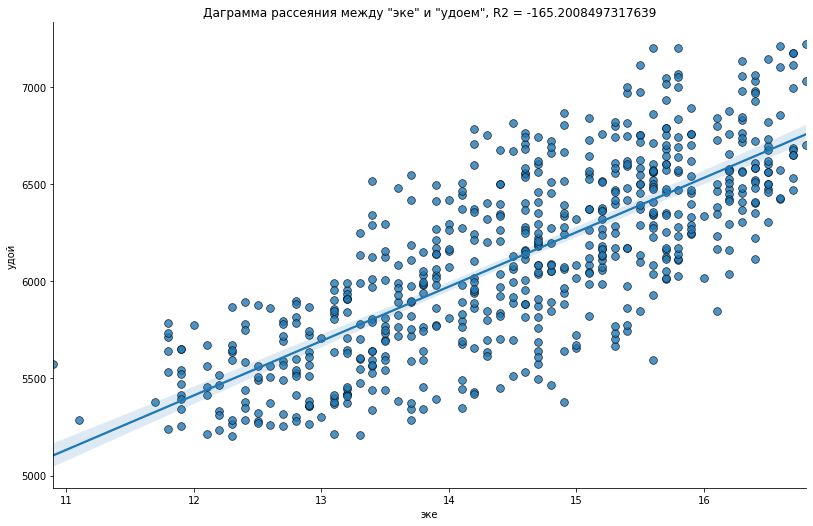

In [563]:
plt.figure(figsize=(4, 8))
lm1 = sns.lmplot(x='эке', y='удой', data=ferma_main, 
                     height=7, aspect=1.6, robust=True, palette='tab10', 
                     scatter_kws=dict(s=60, linewidths=.7, edgecolors='black'))
plt.title(f'Даграмма рассеяния между "эке" и "удоем", R2 = {r2_eke}')
plt.show()

<Figure size 288x576 with 0 Axes>

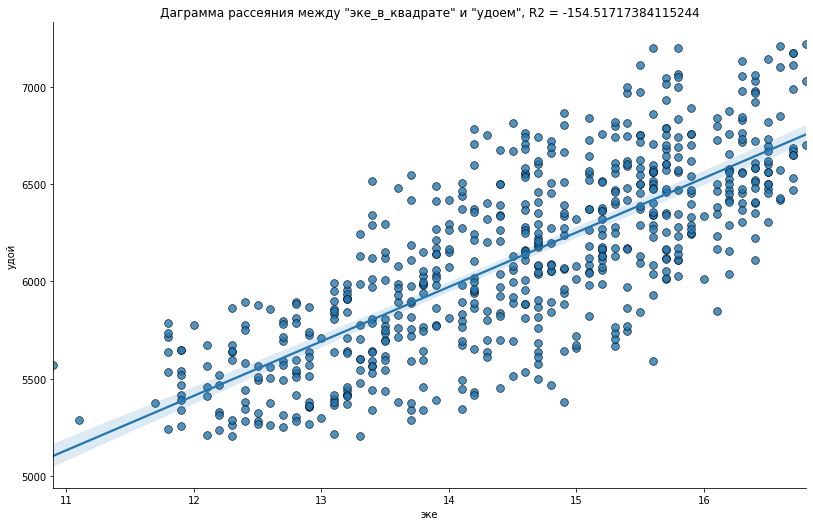

In [564]:
plt.figure(figsize=(4, 8))
lm2 = sns.lmplot(x='эке', y='удой', data=ferma_main, 
                     height=7, aspect=1.6, robust=True, palette='tab10', 
                     scatter_kws=dict(s=60, linewidths=.7, edgecolors='black'))
plt.title(f'Даграмма рассеяния между "эке_в_квадрате" и "удоем", R2 = {r2_eke_2}')
plt.show()

### 4.3 Выводы

#### 4.3.1 Тип взаимосвязи между целевым и входными признаками

Между целым признаком 'удой' и некоторыми входными призаками существует корреляция. Наиболее существенна она с признаками 'спо' (0.79) и 'эке' (0.77). Чуть слабее корреляция с признаком 'жирность' (0.69) и 'сырой_протеин' (0.44). Корреляция с признаком 'белок' отсутствует. 
##### ЭКЕ:
Есть некоторые различия по категориальным признакам. При высоком ЭКЕ преобладают коровы которые пасутся на холмистой местности. Порода папы быка также влияет: наибольший удой у коров, с породой папы - Айдиал. Сильно заментно рапсределение по возрасту: коровы, которым больше 2х лет имеют ЭКЕ (а в следствии и удой) значительно более высокий, чем коровы, которым меньше 2х лет. Так же есть зависимость между  быком папой и удоем. Наибольший удой дают коровы, чей папа Буйный или Геркулес. Присутсвует зависимость с 'удоем'. Причем 'эке' в квадрате имеет более сильную зависимость. Поэтому можно говорит о квадратичной зависимости между 'эке' и 'удоем'.
##### СПО:
Более высокое СПО у коров породы РефлешнСоверинг. Также явно видно, что  СПО выше 0.92 бывает за редким исключением, у коров старше 2х лет. Не смотря на высокую корреляцию с 'удоем', выраженная зависимость отсутсвтует.
##### Сырой протеин:
Категориальные значения в этом признаке распределены примерно равномерно, за исключением возраста коровы. У коров моложп 2х лет, сырого протеина не более 2000 г, в то время как у коров старше, достигает до 2400 г.
##### Жирность:
По жирности особых различий среди категореальных признаков нет.
##### Белок:
Что касательно белка, то при высоком его содержании, молоко с большей вероятностью оказывается вкусным.

#### 4.3.2 Нелинейные связи между целевым и входными признаками

Нелинейная связь присутсвтует между 'удоем' и колонкой 'белок'. При использовании линейной регрессии лучше не брать во внимание этот признак.

#### 4.3.3 Мультиколлинеарность между входными признаками

Самая большая корреляция - корреляция между признаками 'эке' и 'спо'. Она равняется 0.74, но этого недостаточно для мультиколлинеарности. Между остальными признаками корреляци еще ниже. Поэтому мультиколлинеарность отсутствует.

## Обучение модели линейной регрессии

### 5.1 Первая модель

Обучим модель линейной регрессии с целевым признаком 'удой'. Для начала предстоит определиться с входными признаками. Такими признаками являются 'эке' и 'сырой протеин', 'спо', так как между ними и целевым признаком наблюдается высокая корреляция. Так же удой зависит от коровы: от породы, от того, где она пасется (тип пастбища), от породы папы быка и от возраста. Исходя создадим модель линейной регрессии и сделаем прогноз.

Но для начала создадим функцию, которая будет разбивать данные на обучающую и тестовую выборки, кодировать категориальные и стандартизировать числовые параметры и в конце, делать прогноз.

In [565]:
#константа для постоянства деления выборок
RANDOM_STATE = 42
#признаки
X = ferma_main[['эке', 'сырой_протеин', 'тип_пастбища', 'порода', 'порода_папы_быка', 'возраст']]
#целевой признак
y = ferma_main['удой']

#функция для разделения данных на тренировочную и тестовую выборки
def linear_model(X, y, cat_col_names, num_col_names):
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        random_state = RANDOM_STATE
    )
    #создаем энкодер для кодирования категориальных признаков. drop='first' чтобы избавиться от дамми-ловушек. sparse_output=False чтобы в дальшейнем 
    #можно было преобразовать закодированные данные в датафрейм.
    encoder = OneHotEncoder(drop='first', sparse=False)
    #учим энкодер на тренировочной выборке и трансформируем тренировочные данные
    X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
    #трансформируем тестовую выборку
    X_test_ohe = encoder.transform(X_test[cat_col_names])
    #получаем имена закодированных колонок
    encoder_col_names = encoder.get_feature_names()
    #создаем датафреймы с закодированными признаками
    X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

    #создаем скэлер для стандартизации числовых признаков
    scaler = StandardScaler()
    #учим скэлер на тренировочной выборке и трансформируем данные
    X_train_scaled = scaler.fit_transform(X_train[num_col_names])
    #трансформируем данные в тестовой выборке
    X_test_scaled = scaler.transform(X_test[num_col_names]) 
    #создаем датафреймы со стандартизированными преобразованными числовыми признаками
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)
    #создаем наши финальные обновленные выборки из преобразованных категориальных и числовых признаков
    X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
    X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)
    
    #создаем модель
    model_lr = LinearRegression()
    #обучаем модель на тестовой выборке
    model_lr.fit(X_train, y_train)
    #предсказываем значения на тестовой выборке
    prediction = model_lr.predict(X_test)
    r2 = r2_score(y_test, prediction)
    return model_lr, prediction, y_test, r2, encoder, scaler
    

Теперь делаем наш прогноз и смотрим на метрику R2.

In [566]:
#признаки
X = ferma_main[['эке', 'спо', 'сырой_протеин', 'тип_пастбища', 'порода', 'порода_папы_быка', 'возраст']]
#целевой признак
y = ferma_main['удой']
#имена столбцов с категориальными признаками
cat_col_names = ['тип_пастбища', 'порода', 'порода_папы_быка', 'возраст']
#имена столбцов с количественными признаками
num_col_names = ['эке', 'сырой_протеин', 'спо']
model_lr_1, prediction_1, y_test_1, r2_1, encoder_1, scaler_1 = linear_model(X, y, cat_col_names, num_col_names)

In [567]:
r2_1

0.7844078173416966

А также создадим функцию для визуализации остатков и их диаграмму распределения.

In [568]:
def residual(y_test, prediction):
    residuals= y_test - prediction
    plt.figure(figsize=(8, 4))
    plt.suptitle('Анализ остатков', fontsize=14)
    plt.subplots_adjust(left=0.13, 
                    right=0.93, 
                    top=0.80, 
                    bottom= 0.27, 
                    wspace= 0.6, 
                    hspace=0.3)

    plt.subplot(1, 2, 1)
    plt.title('Распределение остатков')
    plt.xlabel('остаток')
    plt.ylabel('количество')
    residuals.hist(bins=30);

    plt.subplot(1, 2, 2)
    plt.title('Диаграмма рассеяния')
    plt.xlabel('предсказание')
    plt.ylabel('остаток')
    sns.scatterplot(x=prediction, y=residuals);
    return residuals

И посмотрим на остатки нашей модели

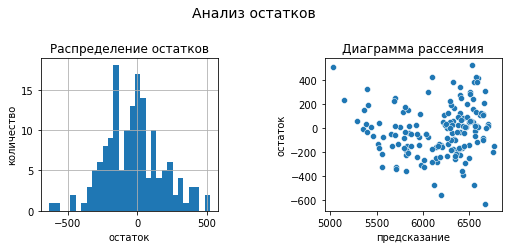

In [569]:
residuals_1 = residual(y_test_1, prediction_1)

#### Вывод

По результатом работы модели на тестовой выборке, мы получили следующие результаты:

##### Метрика R2 = 0.78
Это говорит о том, что модель работает не очень хорошо.

Остатки модели распределены равномерно относительно 0, это хороший знак. Но диаграмма рассеяния имеет форму рупора, что говорит о том, что при предсказании наиболее больших значений, увеличивается размер ошибки. Т. е. модель плохо предсказывает большие значения.

Для улучшения модели нужны дополнительные исследования. Необходимо более тщательно изучить какие признаки влияют на удой, который выше 6000 кг. 

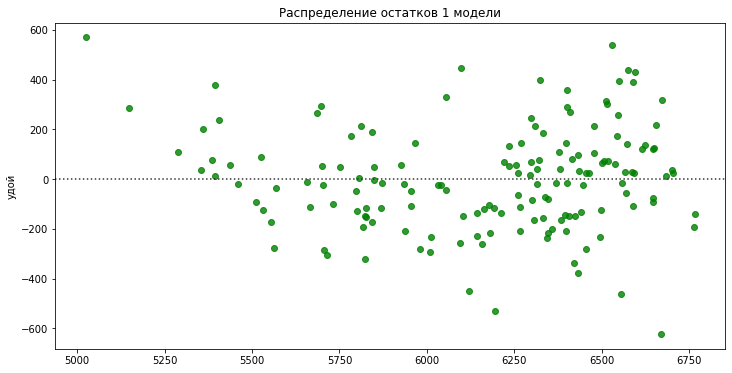

In [570]:
plt.figure(figsize=(12,6))
sns.residplot(x=prediction_1, y=residuals_1, color='g')
plt.title('Распределение остатков 1 модели')
plt.show()

### 5.2 Вторая модель

Для улушения нашей модели улучшим значения в колонке 'эке', путем возведения ее в квадрат. При таком действии зависимость между 'эке' ^ 2 и 'удоем' станет более линейной. Так же для прогноза добавим еще один признак - СПО. Сейчас он нелинейный и на диаграмме рассеяния видно четкое разделение в районе 0.92. Поэтому представим его в категориальном виде, где есть две категории: все что ниже 0.92 и все что выше.

In [571]:
#создадим колонку 'спо' категориальный c 2мя видами значений
ferma_main['спо_категориальный'] = 'больше 0.92'
ferma_main.loc[ferma_main['спо'] < 0.92, 'спо_категориальный'] = 'меньше 0.92'

In [572]:
X = ferma_main[['эке_в_квадрате', 'сырой_протеин', 'тип_пастбища', 'порода', 'порода_папы_быка', 'возраст', 'спо_категориальный']]
#целевой признак
y = ferma_main['удой']#имена столбцов с категориальными признаками
cat_col_names = ['тип_пастбища', 'порода', 'порода_папы_быка', 'возраст', 'спо_категориальный']
#имена столбцов с количественными признаками
num_col_names = ['эке_в_квадрате', 'сырой_протеин']
model_lr_2, prediction_2, y_test_2, r2_2, encoder_2, scaler_2 = linear_model(X, y, cat_col_names, num_col_names)


Оценим качество работы модели c помощью метрики R2

In [573]:
r2_2

0.8180879926867501

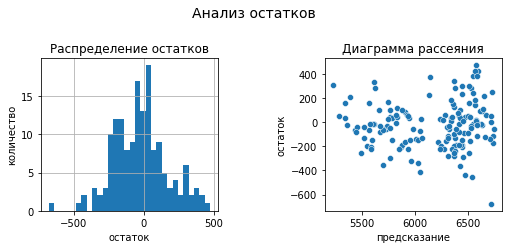

In [574]:
residuals_2 = residual(y_test_2, prediction_2)

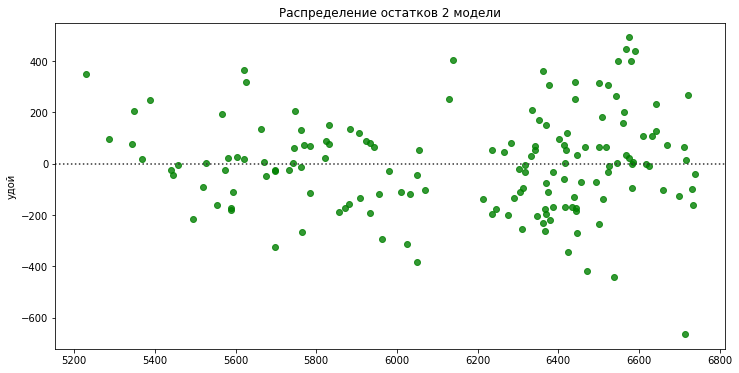

In [575]:
plt.figure(figsize=(12,6))
sns.residplot(x=prediction_2, y=residuals_2, color='g')
plt.title('Распределение остатков 2 модели')
plt.show()

#### Вывод

По результатом работы модели на тестовой выборке, мы получили следующие результаты:

##### Метрика R2 = 0.81

Модель стало более хорошо предсказывать значения. Количество остатков близких к 0 увеличилось. На диаграмме рассения остатков видно, что они стали более равномерно распределенными, хотя при значения выше 6300 еще наблюдается повышенный разброс. Уже лучше, чем было, но еще не идеально.

### 5.3 Третья модель

Для улучшения работы модели добавим новый признак - имя папы, из датафрейма 'ferma_dad'. А так же будем использовать признаки из второй модели (преобразованное 'эке' и категориальное 'спо')

In [576]:
#признаки
X = ferma_main[['эке_в_квадрате', 'сырой_протеин', 'тип_пастбища', 'порода', 'порода_папы_быка', 'имя_папы', 'возраст', 'спо_категориальный']]
#целевой признак
y = ferma_main['удой']
#имена столбцов с категориальными признаками
cat_col_names = ['тип_пастбища', 'порода', 'порода_папы_быка', 'имя_папы', 'возраст', 'спо_категориальный']
#имена столбцов с количественными признаками
num_col_names = ['эке_в_квадрате', 'сырой_протеин']
model_lr_3, prediction_3, y_test_3, r2_3, encoder_3, scaler_3 = linear_model(X, y, cat_col_names, num_col_names)

Оценим качество работы модели на тестовой выборке.

In [577]:
r2_3

0.8247542745210406

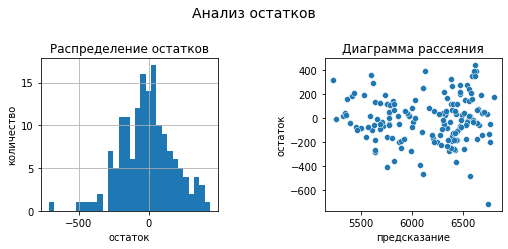

In [578]:
#смотрим на распределение и дисперсию остатков
residuals_3 = residual(y_test_3, prediction_3)

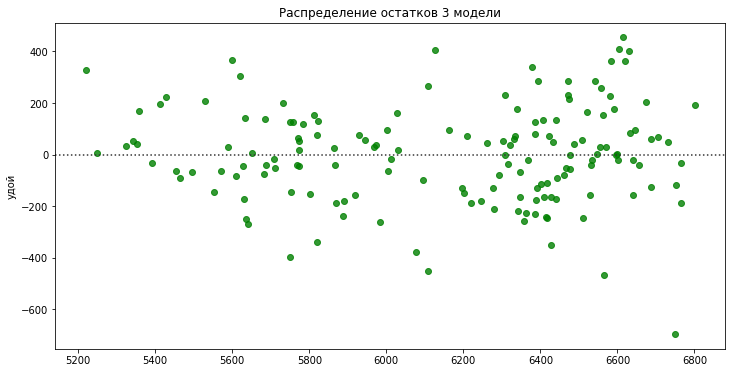

In [579]:
plt.figure(figsize=(12,6))
sns.residplot(x=prediction_3, y=residuals_3, color='g')
plt.title('Распределение остатков 3 модели')
plt.show()

#### Вывод

По результатом работы модели на тестовой выборке, мы получили следующие результаты:

##### Метрика R2 = 0.82

Точность модели увеличилась благодаря добавлению нового признака. Количество результатов с 0 отклонением стало больше, и уменьшился размер остатков при прогнозировании значений с большим удоем.

### 5.4 Сравнения качества моделей

Для сравнения качества моделей сопоставим еще раз их метрики R2 и диаграммы рассеяния отстатков.

##### Первая модель: Метрика R2 = 0.78
##### Вторая модель: Метрика R2 = 0.81
##### Третья модель: Метрика R2 = 0.82

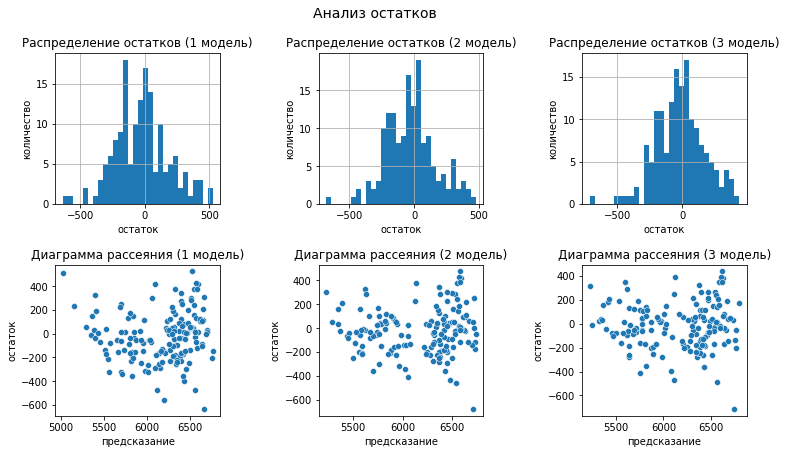

In [580]:
#смотрим на распределение и дисперсию остатков
plt.figure(figsize=(12, 8))
plt.suptitle('Анализ остатков', fontsize=14)
plt.subplots_adjust(left=0.13, 
                    right=0.93, 
                    top=0.90, 
                    bottom= 0.27, 
                    wspace= 0.6, 
                    hspace=0.4)

plt.subplot(2, 3, 1)
plt.title('Распределение остатков (1 модель)')
plt.xlabel('остаток')
plt.ylabel('количество')
residuals_1.hist(bins=30);

plt.subplot(2, 3, 2)
plt.title('Распределение остатков (2 модель)')
plt.xlabel('остаток')
plt.ylabel('количество')
residuals_2.hist(bins=30)

plt.subplot(2, 3, 3)
plt.title('Распределение остатков (3 модель)')
plt.xlabel('остаток')
plt.ylabel('количество')
residuals_3.hist(bins=30)

plt.subplot(2, 3, 4)
plt.title('Диаграмма рассеяния (1 модель)')
plt.xlabel('предсказание')
plt.ylabel('остаток')
sns.scatterplot(x=prediction_1, y=residuals_1)

plt.subplot(2, 3, 5)
plt.title('Диаграмма рассеяния (2 модель)')
plt.xlabel('предсказание')
plt.ylabel('остаток')
sns.scatterplot(x=prediction_2, y=residuals_2)

plt.subplot(2, 3, 6)
plt.title('Диаграмма рассеяния (3 модель)')
plt.xlabel('предсказание')
plt.ylabel('остаток')
sns.scatterplot(x=prediction_3, y=residuals_3)
plt.show()

На графиках видно, как меняется в лучшую сторону прогноз от 1 к 3 модели: уменьшается разброс остатков и увеличивается число предсказаний стремящихся к истинному значению.

### 5.5 Оценка качества моделей с помощью метрик MSE, MAE и RMSE

Создадим функцию, для расчета метрик

In [581]:
def metrics(y_test, prediction):
    mse = mean_squared_error(y_test, prediction)
    rmse = mean_squared_error(y_test, prediction) ** 0.5
    mae = mean_absolute_error(y_test, prediction)
    return mse, rmse, mae

Первая модель:

In [582]:
mse1, rmse1, mae1 = metrics(y_test_1, prediction_1)

Вторая модель:

In [583]:
mse2, rmse2, mae2 = metrics(y_test_2, prediction_2)

Третья модель:

In [584]:
mse3, rmse3, mae3 = metrics(y_test_3, prediction_3)

Создадим таблицу со значениями метрик для различных моделей

In [585]:
metrics = {'metrics' : ['mse', 'rmse', 'mae'], 'model_1'  : [mse1, rmse1, mae1], 'model_2'  : [mse2, rmse2, mae2], 'model_3'  : [mse3, rmse3, mae3]}
metrics = pd.DataFrame(metrics)
metrics

,metrics,model_1,model_2,model_3
0,mse,43887.015010,37030.911311,35673.889886
1,rmse,209.492279,192.434174,188.875329
2,mae,164.241945,149.039652,146.163024


Исходя из метрик так же видно, что лучше всего работает третья модель.

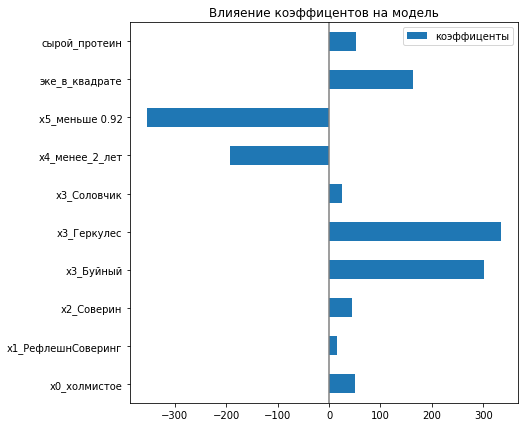

In [586]:
model_lr_3.coef_ 
coefs = pd.DataFrame(
    model_lr_3.coef_, columns=["коэффиценты"], index=['x0_холмистое', 'x1_РефлешнСоверинг', 'x2_Соверин', 'x3_Буйный',
       'x3_Геркулес', 'x3_Соловчик', 'x4_менее_2_лет', 'x5_меньше 0.92',
       'эке_в_квадрате', 'сырой_протеин'])
coefs.plot(kind="barh", figsize=(9, 7))
plt.title("Влияение коэффицентов на модель")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

Видно, что на удой влияют конкретные породы пап быков, а именно 'Геркулес' и 'Буйный'. Так же достаточно сильно влияет СПО, и возраст коровы.

Теперь посмотрим на доверительный интервал прогноза нашей лучшей модели. 

In [587]:
residuals_3.describe()

count    157.000000
mean     -15.201522
std      188.865034
min     -712.793903
25%     -144.381634
50%      -15.967703
75%      112.027110
max      437.597704
Name: удой, dtype: float64

При предсказании наша модель может ошибаться на 144 кг в меньшую сторону и до 112 кг в большую сторону.

### 5.6 Прогноз удоя коров экофермы

Для начала преобразуем датафрейм 'cow_buy' путем добавления к нему колонок с характеристиками корма: 'эке', 'сырой_протеин', 'спо'. Возмьем из датасета 'ferma_main' средние значения этих признаков и увеличим их на 5%.

In [588]:
cow_buy['эке'] = ferma_main['эке'].mean() * 1.05
cow_buy['сырой_протеин'] = ferma_main['сырой_протеин'].mean() * 1.05
cow_buy['спо'] = ferma_main['спо'].mean() * 1.05
#создадим колонку 'спо' категориальный c 2мя видами значений
cow_buy['спо_категориальный'] = 'больше 0.92'
cow_buy.loc[cow_buy['спо'] < 0.92, 'спо_категориальный'] = 'меньше 0.92'
#создадим колонку 'эке_в_квадрате'
cow_buy['эке_в_квадрате'] = cow_buy['эке'] ** 2
cow_buy.head()

,порода,тип_пастбища,порода_папы_быка,имя_папы,текущая_жирность,текущий_уровень_белка,возраст,эке,сырой_протеин,спо,спо_категориальный,эке_в_квадрате
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744,больше 0.92,233.361138
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276162,2019.947532,0.958744,больше 0.92,233.361138
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,2019.947532,0.958744,больше 0.92,233.361138
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,2019.947532,0.958744,больше 0.92,233.361138
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,2019.947532,0.958744,больше 0.92,233.361138


Теперь выполним подготовку данных для дальнейшего прогноза. А именно: представим значения в колонках 'порода', 'тип_пастбища', 'порода_папы_быка', 'имя_папы', 'возраст' при помощи OHE. А числовые значения в оставшихся колонках масштабируем.

In [589]:
#имена столбцов с категориальными признаками
cat_col_names = ['тип_пастбища', 'порода',  'порода_папы_быка', 'имя_папы', 'возраст', 'спо_категориальный']
#имена столбцов с количественными признаками
num_col_names = ['эке_в_квадрате', 'сырой_протеин']

#трансформируем тестовую выборку
cow_buy_ohe = encoder_3.transform(cow_buy[cat_col_names])
#получаем имена закодированных колонок. используем энкодер нашей последней (самой удачной) модели
encoder_cow_buy_col_names = encoder_3.get_feature_names()
#создаем датафреймы с закодированными признаками
cow_buy_ohe = pd.DataFrame(cow_buy_ohe, columns=encoder_cow_buy_col_names)
#трансформируем данные в тестовой выборке. используем скэллер нашей последней (самой удачной) модели
cow_buy_scaled = scaler_3.transform(cow_buy[num_col_names]) 
#создаем датафреймы со стандартизированными преобразованными числовыми признаками
cow_buy_scaled = pd.DataFrame(cow_buy_scaled, columns=num_col_names)
#создаем наши финальные обновленные выборки из преобразованных категориальных и числовых признаков
cow_buy_test = pd.concat([cow_buy_ohe, cow_buy_scaled], axis=1)

Сделаем прогноз и добавим новую колонку 'предсказанный_удой' в датафрейм 'cow_buy' с учетом того, что наша модель может ошибаться на 112 кг в большую сторону.

In [590]:
prediction_4 = model_lr_3.predict(cow_buy_test)
cow_buy['предсказанный_удой'] = prediction_4 - 112

Посмотрим какой процент коров нам подходит

In [591]:
len(cow_buy[cow_buy['предсказанный_удой'] > 6000]) / len(cow_buy)

1.0

#### Вывод

Все коровы предлагаемые 'экофермой' подходят нам для покупки по признаку 'удой'.

## Обучение модели логистической регрессии

### 6.1 Создание модели логистической регрессии

Создадим модель логичстической регрессии, которая будет определять, вкусное ли молоко или нет. Т.е. в качестве целевого признака будет 'вкус_молока'. Вкус молока зависит от характеристик самого молока: его жирности, белка; от коровы, которая его дает, от места, где корова пасется и от характеристик корма, которым она питается. 
Признаки 'жирность' и 'белок' не имеют линейной зависимости с вкусом молока. Но нужно разобраться, как они сказаны со вкусом. Для этого построим график, где будет показано при каких значения этих параметров какое молоко по вкусу преобладает.

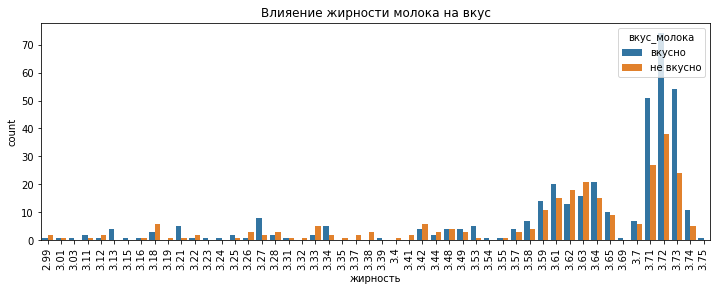

In [592]:
plt.figure(figsize=(12, 4))
plt.title('Влияение жирности молока на вкус')
plt.xticks(rotation=90)
sns.countplot(data=ferma_main, x='жирность', hue='вкус_молока')
plt.show()

По графику видно, что при значениях выше 3.7 начиинается преобладание вкусного молока. Поэтому можно создать новую категориальную колонку на основе колонки 'жирность' и разбить в ней значения на все, что больше 3.7 и все что не больше 3.7.

In [593]:
ferma_main['жирность_категориальный'] = 'больше 3.7'
ferma_main.loc[ferma_main['жирность'] <= 3.7, 'жирность_категориальный'] = 'не больше 3.7'

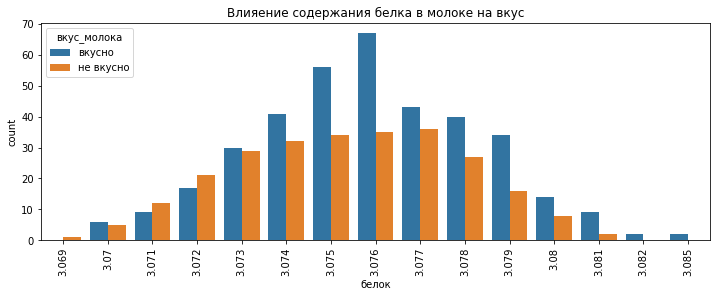

In [594]:
plt.figure(figsize=(12, 4))
plt.title('Влияение содержания белка в молоке на вкус')
plt.xticks(rotation=90)
sns.countplot(data=ferma_main, x='белок', hue='вкус_молока')
plt.show()

Видно, что при значениях белка от 3.074 начниает преобладать вкусное молоко. Поэтому создадим новый категориальный признак 'белок_категориальный' со значениями 'больше 3.073' и 'не больше 3.073'.

In [595]:
ferma_main['белок_категориальный'] = 'больше 3.073'
ferma_main.loc[ferma_main['белок'] <= 3.073, 'белок_категориальный'] = 'не больше 3.073'

Теперь создадим проверочную и тестовую выборку на основе наших признаков, предварительно создав новую колонку, где значения вкуса молока будет представлены в виде  0 и 1 (0 - не вкусно, 1 - вкусно)

In [596]:
ferma_main['вкус_молока_01'] = 1
ferma_main.loc[ferma_main['вкус_молока'] == 'не вкусно', 'вкус_молока_01'] = 0

Создаем тренировочную и тестовую выборки.

In [597]:
#признаки
X = ferma_main[['эке_в_квадрате', 'сырой_протеин', 'тип_пастбища', 'порода', 'порода_папы_быка', 'имя_папы', 'возраст', 'спо_категориальный', \
                'жирность_категориальный', 'белок_категориальный']]
y = ferma_main['вкус_молока_01']
#разбивка данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state = RANDOM_STATE
)

Стандартизируем числовые значения и кодируем категориальные признаки.

In [598]:
#имена столбцов с категориальными признаками
cat_col_names = ['тип_пастбища', 'порода', 'порода_папы_быка', 'имя_папы', 'возраст', 'спо_категориальный', \
                'жирность_категориальный', 'белок_категориальный']
#имена столбцов с количественными признаками
num_col_names = ['эке_в_квадрате', 'сырой_протеин']

#создаем энкодер для кодирования категориальных признаков. drop='first' чтобы избавиться от дамми-ловушек. sparse_output=False чтобы в дальшейнем 
#можно было преобразовать закодированные данные в датафрейм.
encoder = OneHotEncoder(drop='first', sparse=False)
#учим энкодер на тренировочной выборке и трансформируем тренировочные данные
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
#трансформируем тестовую выборку
X_test_ohe = encoder.transform(X_test[cat_col_names])
#получаем имена закодированных колонок
encoder_col_names = encoder.get_feature_names()
#создаем датафреймы с закодированными признаками
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

#создаем скэлер для стандартизации числовых признаков
scaler = StandardScaler()
#учим скэлер на тренировочной выборке и трансформируем данные
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
#трансформируем данные в тестовой выборке
X_test_scaled = scaler.transform(X_test[num_col_names]) 
#создаем датафреймы со стандартизированными преобразованными числовыми признаками
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)
#создаем наши финальные обновленные выборки из преобразованных категориальных и числовых признаков
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

Создаем модель логистической регрессии, обучаем ее и делаем предсказания.

In [599]:
clf = LogisticRegression()
clf = clf.fit(X_train, y_train)
prediction_5 = clf.predict(X_test)

Теперь посмотрим на метрики, которые характеризуют нашу модель.

In [600]:
recall = recall_score(y_test, prediction_5)
precision = precision_score(y_test, prediction_5)
accuracy  = accuracy_score(y_test, prediction_5)
print('accuracy: ', round(accuracy ,2))
print('recall: ', round(recall ,2))
print('precision: ', round(precision,2))

accuracy:  0.62
recall:  0.84
precision:  0.62


Теперь нарисуем матрицу ошибок нашей модели.

Text(0.5, 15.0, 'предсказанные значения')

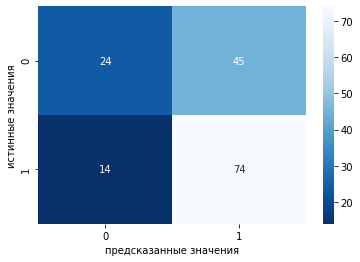

In [601]:
cm = confusion_matrix(y_test, prediction_5)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('истинные значения')
plt.xlabel('предсказанные значения')

### 6.2 Анализ модели логистической регрессии

#### Определение наиболее важной метрики

Точность нашей модели по метрике 'accuracy' получилась равной 0.62. Это не очень хорошая точность. Метрика recall равняется 0.84. Она показывает нам скольки коровам, дающим вкусное молоко, она смогла верно присвоить метку. Метрика precision, равная 0.62, показывает с какой точностью наша модель угадывает коров с вкусным молоком. Для фермера более критичной является ошибка первого рода (False Positive), чем второго (False Negative). Ведь в первом случае он выбирает корову, которая по итогу ему не подходит и в итоге его бизнес несет убыток. А во втором случает он не покупает корову, которая ему подходит. Тут он тоже теряет, но меньше. Поэтому для нас более важной метрикой будет являться precision, где мы должны минимизировать результат False Positive.

#### Сведение критической ошибки к 0

Посмотрим на коэффиценты и валидационные данные, при пороге 0.5, сохранив это все в новую таблицу 'data'.

In [602]:
y_proba = clf.predict_proba(X_test)[:,1]
data = pd.DataFrame(zip(y_test, y_proba),
             columns = ['y_valid', 'y_proba']).sort_values(by='y_proba',ascending=False)

data.head(10)

,y_valid,y_proba
147,1,0.885668
85,1,0.874719
110,1,0.847282
54,0,0.842813
25,1,0.829281
146,1,0.827015
14,1,0.818827
66,1,0.817899
8,1,0.804442
18,1,0.803495


Попробуем поменять порог и посмотрим в зависимости от этого как изменится наши предсказания. Нам нужно избавиться от ошибки False Positive. То есть там, где в валидационной выборке стоит 0, в нашем предсказании тоже должен оказаться 0. И так со всем значениями.  Возьмем 100 чисел в промежутке от 0.1 до 1 и найдем минимальный порог, при котором ошибка False Pasitive станет равно 0.

In [603]:
#создаем список из 20 чисел от 0.5до 1
thresholds = [round(i,2) for i in np.linspace(0.5,1,num = 20,endpoint=False)]
#создаем пустой список для хранения названия колонок
columns = []
#цикл по всем созданным числам. в каждой итерации добавляем новое название в список 'columns' и в 'data' добавляем новую колонку. значения в ней 0 или 1
#в зависимости от того, больше ли число порогового или нет.
for i in thresholds:
	columns.append('y_pred_'+str(i))
	data['y_pred_'+str(i)] = data['y_proba'].apply(lambda x: 1 if x >= i else 0)



Теперь найдем такую колонку при которой ошибка False Positive = 0. Для этого возьмем часть датафрейма 'data', где реальные значения = 0.

In [604]:
data_0 = data[data['y_valid'] == 0]

И пойдем по всем колонкам считать их суммы. Первая колонка, сумма чисел которой будет = 0 - будет являться минимальным порогом избавления от ошибки False Positive.

In [605]:
for i in data_0.columns[2:]:
    if data_0[i].sum() == 0:
        break
print(i)
 

y_pred_0.85


Получилось, что при пороге 0.85 фермер не допустит ошибку False Positive. Отобразим это на графике.

Text(0.5, 15.0, 'предсказанные значения')

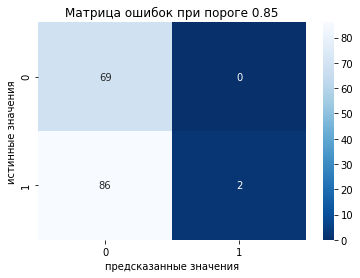

In [606]:
cm1 = confusion_matrix(data['y_valid'], data['y_pred_0.85'])
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues_r')
plt.title('Матрица ошибок при пороге 0.85')
plt.ylabel('истинные значения')
plt.xlabel('предсказанные значения')

In [607]:
recall_085 = recall_score(data['y_valid'], data['y_pred_0.85'])
precision_085 = precision_score(data['y_valid'], data['y_pred_0.85'])

print('recall: ', round(recall_085, 2))
print('precision: ', round(precision_085, 2))

recall:  0.02
precision:  1.0


#### Вывод

Для фермера более критичной ошибкой является False Positive, т.е. купить корову, которая по его предположению окажется подходящей, а на самом деле - нет: молоко будет невкусным. Важно сократить такую ошибку до 0, при этом будут коровы с вкусным молоком, которых фермер не отберет, зато не получит коров с невкусным молоком. В связи с этим нам наиболее важна метрике precission. При стандартном пороге отбора 0.5 наша модель логистической регрессии допускает ошибку FP в 45 случаях, метрика precision при этом равна 0.62. Были исследованы другие пороги, и получилось, что при пороге 0.85 ошибка FP исчезнет и метрика precision станет равной 1. При этом фермер отберет только 2 коров с вкусным молоком (против 74 при пороге 0.5), зато не понесет убытков из-за коров с невкусным молоком.

Поэтому нужно заново обучить нашу модель, но уже с пороговым значением отбора 0.85. И потом уже с помощью этой модели спрогнозировать вкус молока коров 'экофермы'.

### 6.3 Прогнозирование вкуса молока коров 'экофермы'

Для начала подготовим данные в датасете экофермы. Во первых, создадим аналогичные колонки 'жирность_категориальный' и 'белок_категориальный', как делали с датасетом 'ferma_main'.

In [608]:
cow_buy['жирность_категориальный'] = 'больше 3.7'
cow_buy.loc[ferma_main['жирность'] <= 3.7, 'жирность_категориальный'] = 'не больше 3.7'
cow_buy['белок_категориальный'] = 'больше 3.073'
cow_buy.loc[ferma_main['белок'] <= 3.073, 'белок_категориальный'] = 'не больше 3.073'

Далее стандартизируем скалярные значения и закодируем котегориальные

In [609]:
cat_col_names = ['тип_пастбища', 'порода', 'порода_папы_быка', 'имя_папы', 'возраст', 'спо_категориальный', \
                'жирность_категориальный', 'белок_категориальный']
#имена столбцов с количественными признаками
num_col_names = ['эке_в_квадрате', 'сырой_протеин']

#трансформируем тестовую выборку
cow_buy_ohe = encoder.transform(cow_buy[cat_col_names])
#получаем имена закодированных колонок
encoder_cow_buy_col_names = encoder.get_feature_names()
#создаем датафреймы с закодированными признаками
cow_buy_ohe = pd.DataFrame(cow_buy_ohe, columns=encoder_cow_buy_col_names)

#трансформируем данные в тестовой выборке
cow_buy_scaled = scaler.transform(cow_buy[num_col_names]) 
#создаем датафреймы со стандартизированными преобразованными числовыми признаками
cow_buy_scaled = pd.DataFrame(cow_buy_scaled, columns=num_col_names)
#создаем наши финальные обновленные выборки из преобразованных категориальных и числовых признаков
cow_buy_test = pd.concat([cow_buy_ohe, cow_buy_scaled], axis=1)

Сделаем прогноз и посчитаем процент коров с вкусным молоком. Но нужно учесть, что нам нужен порог 0.8, а не 0.5

In [610]:
#делаем предсказание с помощью нашей ранее обученной модели
predictions6 = clf.predict(cow_buy_test)
#смотрим на коэффиценты, которые расчитала модель
y_proba = clf.predict_proba(cow_buy_test)[:,1]
#заносим спрогнозированные коэффиценты в новую колонку 'y_proba'
cow_buy['y_proba'] = y_proba
#создаем колонку 'вкус_молока' и делаем фильтр, что молоко вкусное y_proba >= 0.8
cow_buy['предсказанный_вкус_молока'] = 'не вкусно'
cow_buy.loc[cow_buy['y_proba'] >= 0.85 ,'предсказанный_вкус_молока'] = 'вкусно'

Посмотрим, сколько коров точно дают вкусное молоко.

In [611]:
cow_buy['предсказанный_вкус_молока'].value_counts()

не вкусно    16
Name: предсказанный_вкус_молока, dtype: int64

Получилось, что все коровы дают не вкусное молоко, при пороге 0.85 нашей модели логистической регрессии.

Но возможно в наших данных есть шумы, и в результате модель обучилась не идеально (выше были отклонения по белку и по жирности свыше std, а это важные признаки молока), поэтому можно немного снизить порог. Например взять порог равный 0.7. И посмотреть прогноз при нем.

In [612]:
cow_buy['предсказанный_вкус_молока_07'] = 'не вкусно'
cow_buy.loc[cow_buy['y_proba'] >= 0.7 ,'предсказанный_вкус_молока_07'] = 'вкусно'
cow_buy['предсказанный_вкус_молока_07'].value_counts()

не вкусно    14
вкусно        2
Name: предсказанный_вкус_молока_07, dtype: int64

Получилось, что при таком пороге по вкусу молока, нам подходят две коровы.

## Итоговые выводы

##### Преобразование датафрейма 'cow_buy'

Вернем наш датафрейм к исходным данным, оставив лишь колонки с прогнозами для большей информативности.

In [613]:
cow_buy = cow_buy.drop(columns=['эке', 'сырой_протеин', 'спо', 'спо_категориальный', 'эке_в_квадрате', 'жирность_категориальный', \
                                'белок_категориальный',  'y_proba'], axis=1)
cow_buy

,порода,тип_пастбища,порода_папы_быка,имя_папы,текущая_жирность,текущий_уровень_белка,возраст,предсказанный_удой,предсказанный_вкус_молока,предсказанный_вкус_молока_07
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6497.919297,не вкусно,не вкусно
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,6266.711028,не вкусно,не вкусно
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,6171.999775,не вкусно,не вкусно
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,6481.089377,не вкусно,не вкусно
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,6430.146066,не вкусно,не вкусно
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,6313.380218,не вкусно,не вкусно
6,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,6459.259737,не вкусно,не вкусно
7,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,6288.540668,не вкусно,не вкусно
8,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.055,более_2_лет,6232.707860,не вкусно,не вкусно
9,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,6505.928926,не вкусно,не вкусно


##### Отбор коров, подходящих фермеру

Посмотрим сколько коров подходит фермеру, а именно с удоем больше 6000 кг и с вкусным молоком

In [614]:
len(cow_buy[(cow_buy['предсказанный_удой'] > 6000) & (cow_buy['предсказанный_вкус_молока'] == 'вкусно')])

0

Фермеру не подходит ни одна из предложенных коров.

Но если снизить порог отбора по вкусу молока до 0.7, то нам подойдут две коровы.

In [615]:
len(cow_buy[(cow_buy['предсказанный_удой'] > 6000) & (cow_buy['предсказанный_вкус_молока_07'] == 'вкусно')])

2

Коровы, которые подойдут фермеру при пороге 0.7

In [616]:
cow_buy[(cow_buy['предсказанный_удой'] > 6000) & (cow_buy['предсказанный_вкус_молока_07'] == 'вкусно')]

,порода,тип_пастбища,порода_папы_быка,имя_папы,текущая_жирность,текущий_уровень_белка,возраст,предсказанный_удой,предсказанный_вкус_молока,предсказанный_вкус_молока_07
11,Вис Бик Айдиал,холмистое,Соверин,Барин,3.42,3.075,менее_2_лет,6015.474742,не вкусно,вкусно
12,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.065,более_2_лет,6481.089377,не вкусно,вкусно


##### Результат работы моделей

Получилось, что с минимальным риском для себя фермер не может купить ни одну корову. Если по удою некоторые коровы подходят, то по вкусу молока без риска не получится отобрать коров. Так как порог отбора по этому признаку достаточно высокий.
Можно рекомендовать фермеру подумать на критерием 'вкус молока': если бы чуть-чуть опустить эту планку, то некоторые коровы из 'экофермы' бы прошли. Так же в исходных данных фермера могут быть шумы, поэтому порог можно немного занизить,и тогда фермеру подойдут две коровы, под номером 11 и 12.

##### Выводы о моделях линейной и логистической регрессии

Для улучшения качества модели линейной регрессии мы сделали один из признаков более линейно-зависимым от прогнозируемого. Для этого мы возвели его в квадрат. Так же одну скалярную колонку, которая никак не коррелировала с целевым признаком, мы привели к категориальному типу. Это тоже помогло улучшить нашу модель.

Для дальнейшего улучшения модели линейной регрессии, нужно разбираться с выбросами, изучать конкретных коров, и делать вывод, можно ли их выкинуть или нет, для улучшения наших данных.

При анализе рисков важны метрики логистической регресии: precision и recall. В нашем случае главной метрикой была precision, которая отображает ошибки типа False Positive, ведь если бы фермер неверно распознал корову, то это были бы большие финансовые потери: покупка неподходящих коров.